# Model Validation Notebook

This notebook provides a comprehensive validation for all implemented time series generative models (parametric and non-parametric). It covers the entire pipeline from data preprocessing to model training and synthetic data generation, ensuring that each model functions as expected and produces output in the desired format `(R, l, N)`.

## Table of Contents:
1.  [Setup and Imports](#Setup-and-Imports)
2.  [Data Preprocessing](#Data-Preprocessing)
3.  [Parametric Model Validation](#Parametric-Model-Validation)
    *   [Geometric Brownian Motion](#Geometric-Brownian-Motion)
    *   [Ornstein-Uhlenbeck Process](#Ornstein-Uhlenbeck-Process)
4.  [Non-Parametric Model Validation](#Non-Parametric-Model-Validation)
    *   [Vanilla GAN](#Vanilla-GAN)
    *   [Wasserstein GAN](#Wasserstein-GAN)



In [1]:
import sys
import numpy as np
import torch
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
project_root = Path().resolve().parents[0]
sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

from src.preprocessing.preprocessing import preprocess_data
from src.preprocessing.transformers import (
    TimeSeriesDataset,
    create_dataloaders
)

from src.utils.dat_io_utils import read_csv_data

from src.models.base.base_model import ParametricModel, DeepLearningModel
from src.models.parametric.gbm import GeometricBrownianMotion
from src.models.parametric.ou_process import OrnsteinUhlenbeckProcess
from src.models.parametric.merton_jump_diffusion import MertonJumpDiffusion
from src.models.parametric.garch11 import GARCH11
from src.models.parametric.de_jump_diffusion import DoubleExponentialJumpDiffusion

from src.models.non_parametric.vanilla_gan import VanillaGAN
from src.models.non_parametric.wasserstein_gan import WassersteinGAN

print("All necessary modules imported successfully!")

Project root added to sys.path: C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main
All necessary modules imported successfully!


## Data Preprocessing

This section demonstrates how to preprocess a sample dataset (`GOOG.csv`) using the provided utilities and create PyTorch `DataLoader` objects. This data will be used to train and validate our generative models.



In [2]:
# --- Normalized; Non-parametric case; Batched time series ---
config_non_parametric = {
    'original_data_path': str(project_root / 'data' / 'raw' / 'GOOG' / 'GOOG.csv'),
    'valid_ratio': 0.1,
    'do_normalization': True,
    'seed': 42
}

print(f"Preprocessing normalized data with config: {config_non_parametric}")

train_data_norm_np, valid_data_norm_np = preprocess_data(config_non_parametric)

batch_size = 32
train_loader_norm, valid_loader_norm = create_dataloaders(
    train_data_norm_np, valid_data_norm_np,
    batch_size=batch_size,
    train_seed=42,
    valid_seed=123,
    num_workers=0,
    pin_memory=False
)

print(f"\n[Normalized] Train data shape: {train_data_norm_np.shape}")
print(f"[Normalized] Valid data shape: {valid_data_norm_np.shape}")
print(f"[Normalized] Number of training batches: {len(train_loader_norm)}")
print(f"[Normalized] Number of validation batches: {len(valid_loader_norm)}")

num_samples_real, length, num_channels = train_data_norm_np.shape
print(f"\n[Normalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")



Preprocessing normalized data with config: {'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'do_normalization': True, 'seed': 42}
Data preprocessing with settings:{'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'do_normalization': True, 'seed': 42}
Data shape: (1132, 125, 6)
Preprocessing done.


[Normalized] Train data shape: (1018, 125, 6)
[Normalized] Valid data shape: (114, 125, 6)
[Normalized] Number of training batches: 32
[Normalized] Number of validation batches: 4

[Normalized] Inferred model output dimensions: length=125, num_channels=6


C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main\src\utils\dat_io_utils.py:38: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['Date'] = df['Date'].view('int64') // 10**9


In [3]:
# --- Unnormalized; Parametric Case; Use full time series ---
config_parametric = {
    'original_data_path': str(project_root / 'data' / 'raw' / 'GOOG' / 'GOOG.csv'),
    'valid_ratio': 0.1,
    'is_parametric': True
}

print(f"Preprocessing full dataset with configs: {config_non_parametric}")

train_data_para, valid_data_para = preprocess_data(config_parametric)

# Type checks for processed data
print(f"\n[Unnormalized] Type of train_data_para: {type(train_data_para)}")
print(f"[Unnormalized] Type of valid_data_para: {type(valid_data_para)}")
print(f"[Unnormalized] Train data shape: {train_data_para.shape}")
print(f"[Unnormalized] Valid data shape: {valid_data_para.shape}")

length, num_channels = train_data_para.shape
print(f"\n[Unnormalized] Inferred model output dimensions: length={length}, num_channels={num_channels}")

Preprocessing full dataset with configs: {'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'do_normalization': True, 'seed': 42}
Data preprocessing with settings:{'original_data_path': 'C:\\Users\\14165\\Downloads\\Unified-benchmark-for-SDGFTS-main\\data\\raw\\GOOG\\GOOG.csv', 'valid_ratio': 0.1, 'is_parametric': True}
Data shape: (1256, 6)

[Unnormalized] Type of train_data_para: <class 'torch.Tensor'>
[Unnormalized] Type of valid_data_para: <class 'torch.Tensor'>
[Unnormalized] Train data shape: torch.Size([1130, 6])
[Unnormalized] Valid data shape: torch.Size([126, 6])

[Unnormalized] Inferred model output dimensions: length=1130, num_channels=6


C:\Users\14165\Downloads\Unified-benchmark-for-SDGFTS-main\src\utils\dat_io_utils.py:38: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['Date'] = df['Date'].view('int64') // 10**9


## Stochastic Model Validation

This section validates the functionality of each stochastic time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.



In [4]:
def plot_outputs(train_data_para, generated_data, num_generated_samples, length):
    """
    Assumes train_data_para and generated_data have 6 channels:
      Channel 0: timestep (not forecasted)
      Channels 1: Open
      Channel 2: Close
      Channel 3: High
      Channel 4: Low
      Channel 5: Volume
    Plots each forecasted channel's statistics and overlay vs generated samples.
    """


    channel_names = ["Time", "Open", "Close", "High", "Low", "Volume"]
    for c in range(1, 6):  # 1 to 5 (Open, Close, High, Low, Volume)
        chan_data = generated_data[..., c]
        min_val = chan_data.min().item()
        max_val = chan_data.max().item()
        mean_val = chan_data.mean().item()
        print(f"{channel_names[c]} (channel {c}): min={min_val:.4f}, max={max_val:.4f}, mean={mean_val:.4f}")
        
        plt.figure(figsize=(12, 5))
        # Real training series for this channel
        y_real = train_data_para[:, c].cpu().numpy() if hasattr(train_data_para, "cpu") else train_data_para[:, c]
        plt.plot(range(length), y_real, label="Original Train", color='blue', linewidth=2)
        # Plot a few generated samples
        for i in range(num_generated_samples):
            y_fake = generated_data[i, :, c].cpu().numpy() if hasattr(generated_data, "cpu") else generated_data[i, :, c]
            plt.plot(
                range(length), y_fake,
                alpha=0.7, linestyle="--", color='orange' if i == 0 else 'gray',
                label="Generated" if i == 0 else None)
        plt.title(f"{channel_names[c]}: Original vs Generated Samples")
        plt.xlabel("Time Step")
        plt.ylabel(channel_names[c])
        plt.legend()
        plt.tight_layout()
        plt.show()

### Geometric Brownian Motion




Validating Geometric Brownian Motion (GBM)
GBM Model instantiated: <src.models.parametric.gbm.GeometricBrownianMotion object at 0x000001ECC2141CA0>
Fitting GBM model...
Generated GBM data shape: torch.Size([10, 1130, 6])
GBM: Generated data shape is correct.
Open (channel 1): min=34.1405, max=328.9049, mean=109.6073


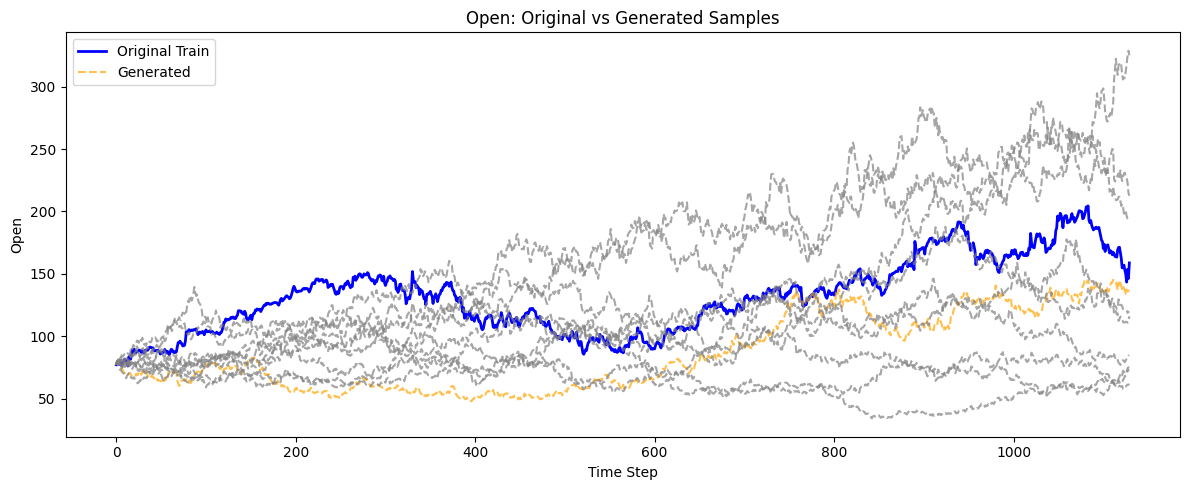

Close (channel 2): min=34.1405, max=328.9049, mean=109.6622


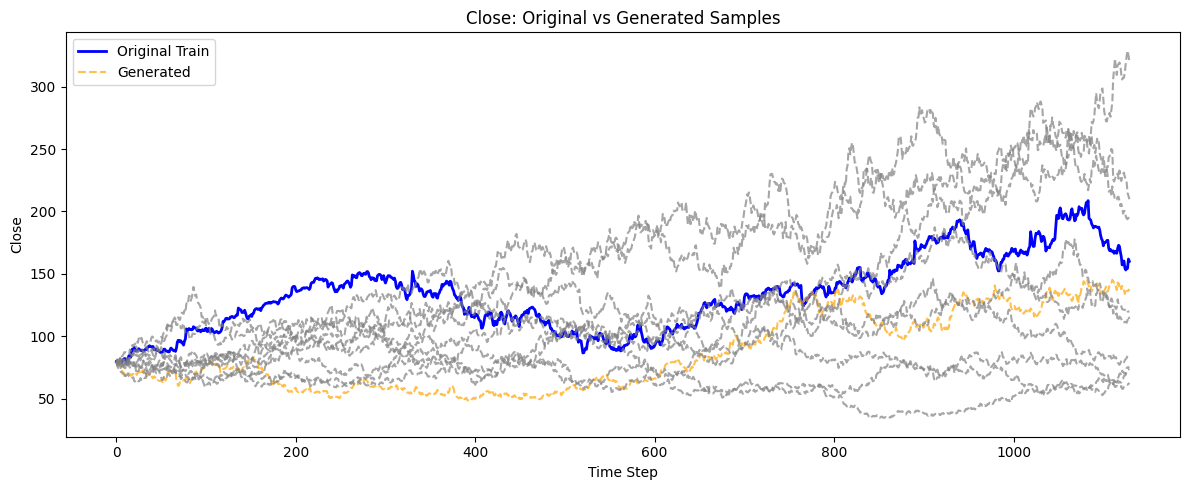

High (channel 3): min=34.6626, max=328.9049, mean=110.4751


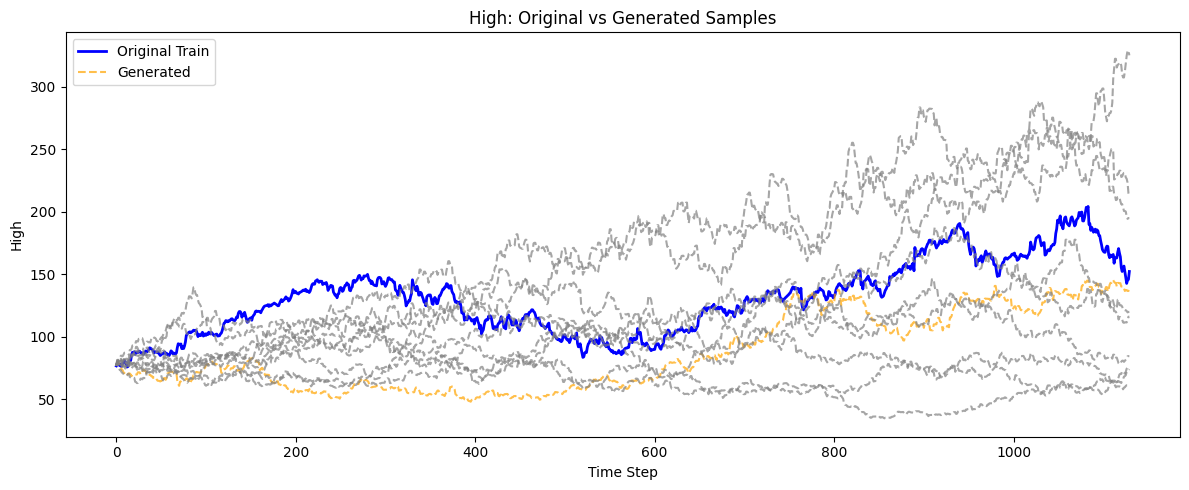

Low (channel 4): min=34.1405, max=325.2054, mean=108.7929


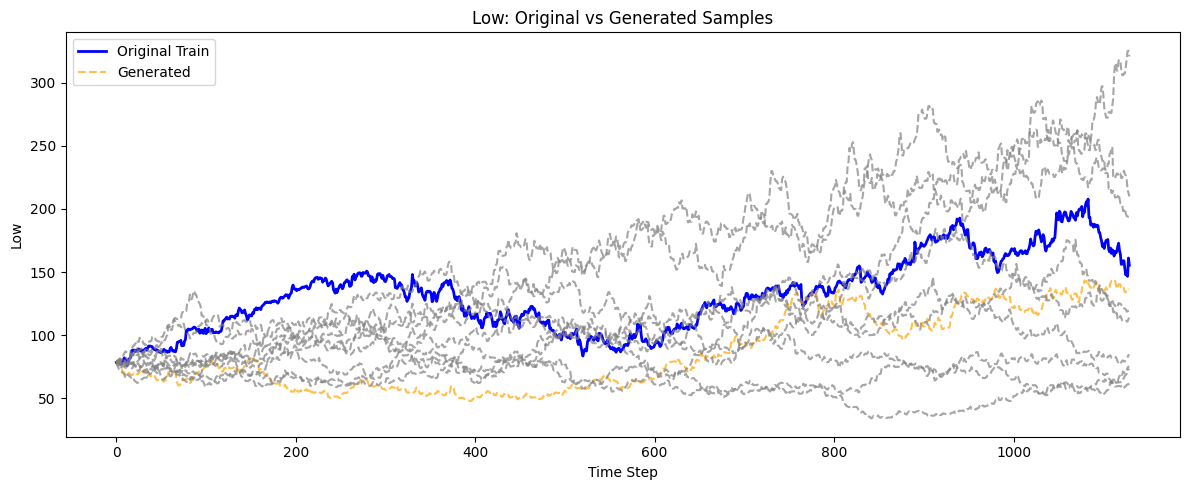

Volume (channel 5): min=0.1747, max=20925513873693343744.0000, mean=35192150274605056.0000


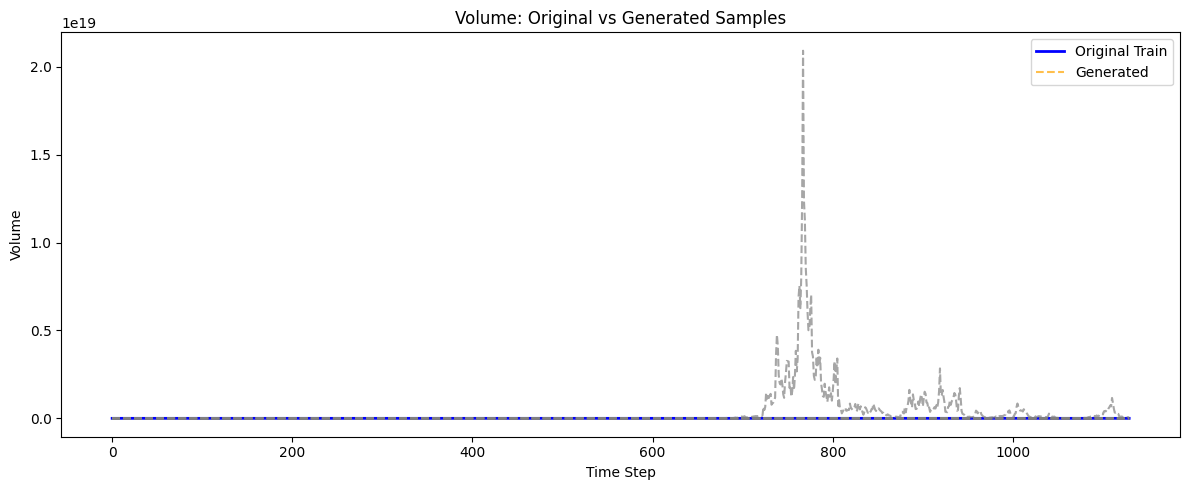

In [5]:
print("\n" + "=" * 50)
print("Validating Geometric Brownian Motion (GBM)")
print("=" * 50)


length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

gbm_model = GeometricBrownianMotion(length=length, num_channels=num_channels, initial_price=initial_price)
print(f"GBM Model instantiated: {gbm_model}")

print("Fitting GBM model...")
gbm_model.fit(train_data_para)

num_generated_samples = 10
gbm_generated_data = gbm_model.generate(num_generated_samples)
print(f"Generated GBM data shape: {gbm_generated_data.shape}")

assert gbm_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"GBM: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {gbm_generated_data.shape}"
print("GBM: Generated data shape is correct.")

plot_outputs(train_data_para, gbm_generated_data, num_generated_samples, length)

### Ornstein-Uhlenbeck Process




Validating Ornstein-Uhlenbeck (O-U) Process
O-U Model instantiated: <src.models.parametric.ou_process.OrnsteinUhlenbeckProcess object at 0x000001ECC0DEC620>
Fitting O-U model...
Generated O-U data shape: torch.Size([10, 1130, 6])
O-U: Generated data shape is correct.
Open (channel 1): min=59.3369, max=222.5522, mean=135.7166


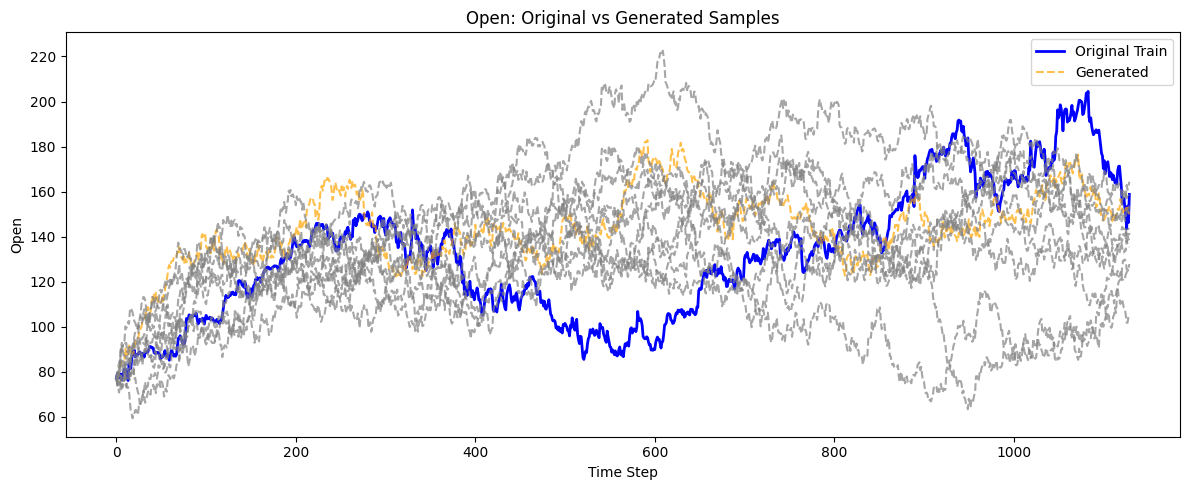

Close (channel 2): min=56.9824, max=240.7474, mean=140.7630


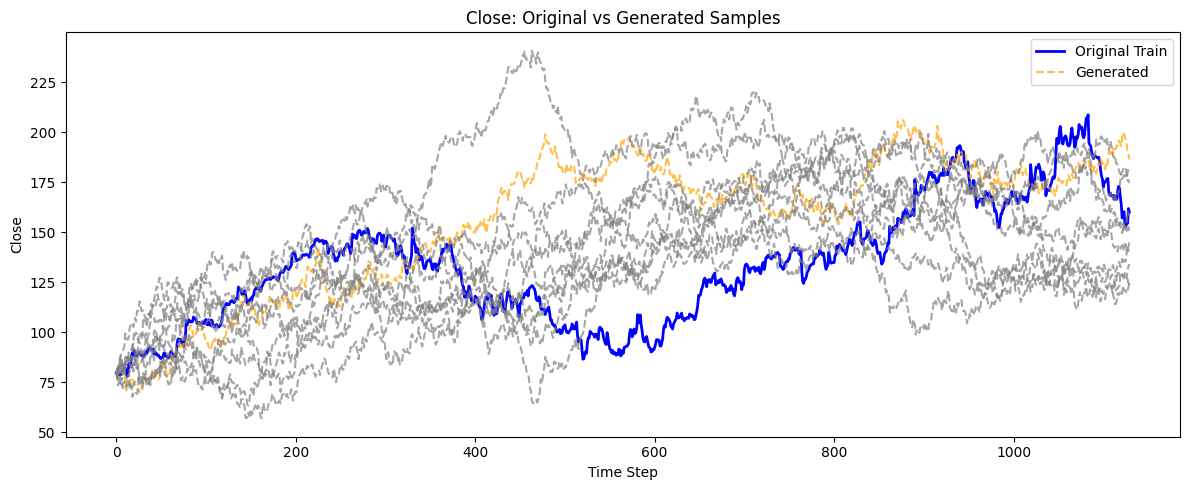

High (channel 3): min=64.2115, max=209.1192, mean=131.5398


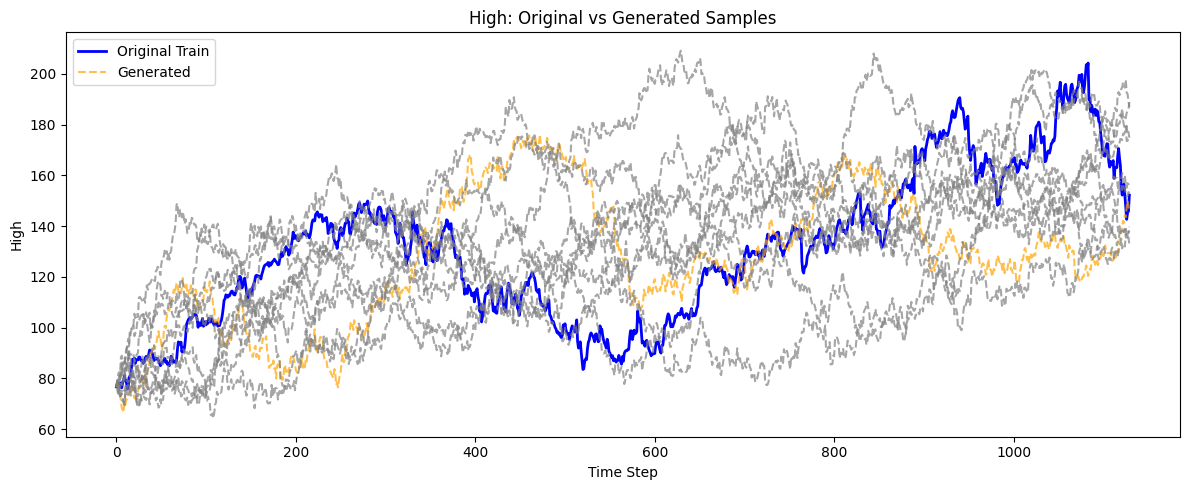

Low (channel 4): min=51.7781, max=217.5074, mean=134.4551


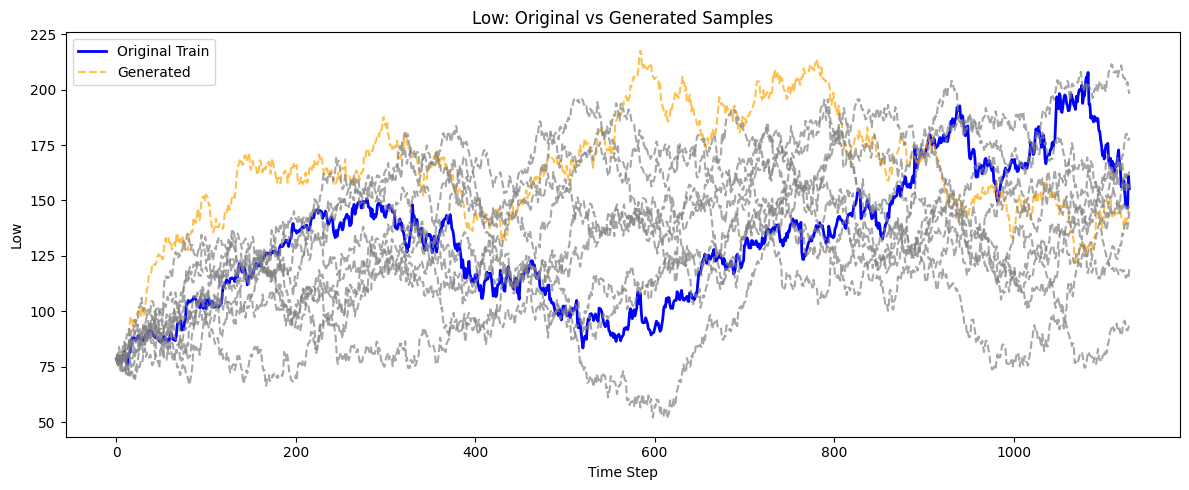

Volume (channel 5): min=-14884330.0000, max=64635724.0000, mean=25013700.0000


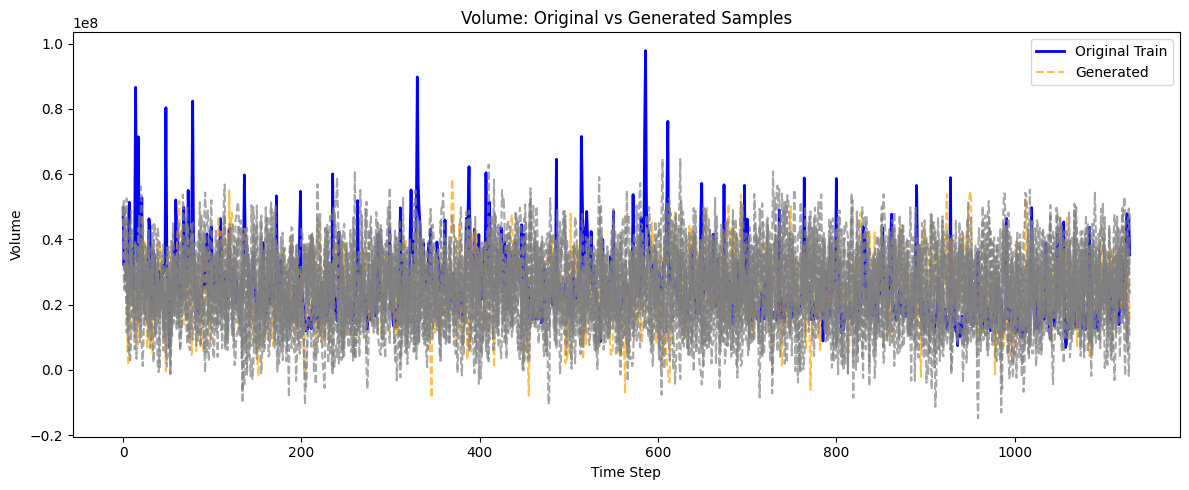

In [6]:
print("\n" + "=" * 50)
print("Validating Ornstein-Uhlenbeck (O-U) Process")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

ou_model = OrnsteinUhlenbeckProcess(length=length, num_channels=num_channels)
print(f"O-U Model instantiated: {ou_model}")

print("Fitting O-U model...")
ou_model.fit(train_data_para)

num_generated_samples = 10
ou_generated_data = ou_model.generate(num_generated_samples)
print(f"Generated O-U data shape: {ou_generated_data.shape}")

assert ou_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"O-U: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {ou_generated_data.shape}"
print("O-U: Generated data shape is correct.")

plot_outputs(train_data_para, ou_generated_data, num_generated_samples, length)

### Merton Jump Diffusion


Validating Merton Jump Diffusion (MJD)
MJD Model instantiated: <src.models.parametric.merton_jump_diffusion.MertonJumpDiffusion object at 0x000001ECC24F0110>
Fitting MJD model...
Generated MJD data shape: torch.Size([10, 1130, 6])
MJD: Generated data shape is correct.
Open (channel 1): min=58.1603, max=603.3157, mean=153.1297


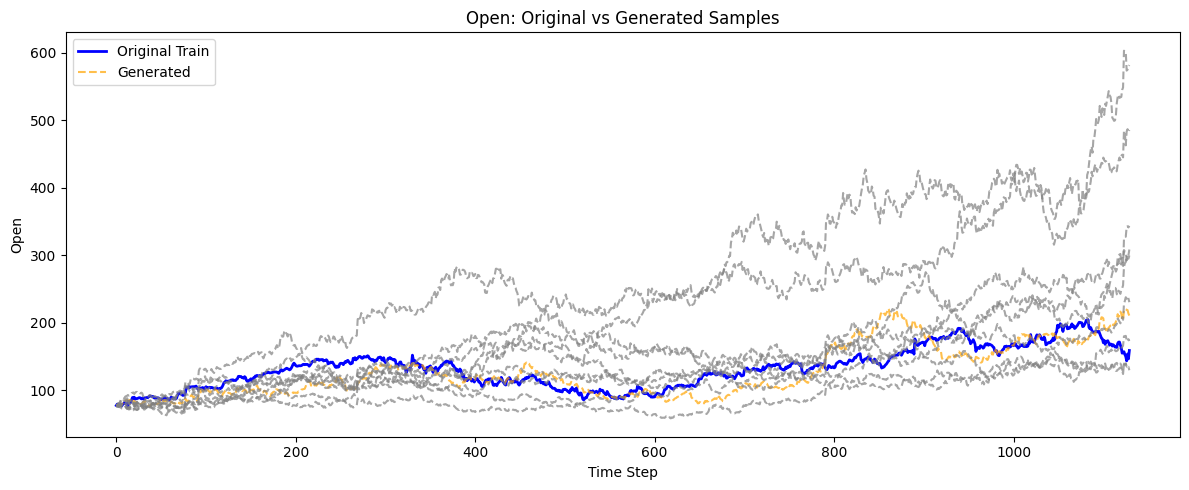

Close (channel 2): min=45.9946, max=436.8867, mean=133.6186


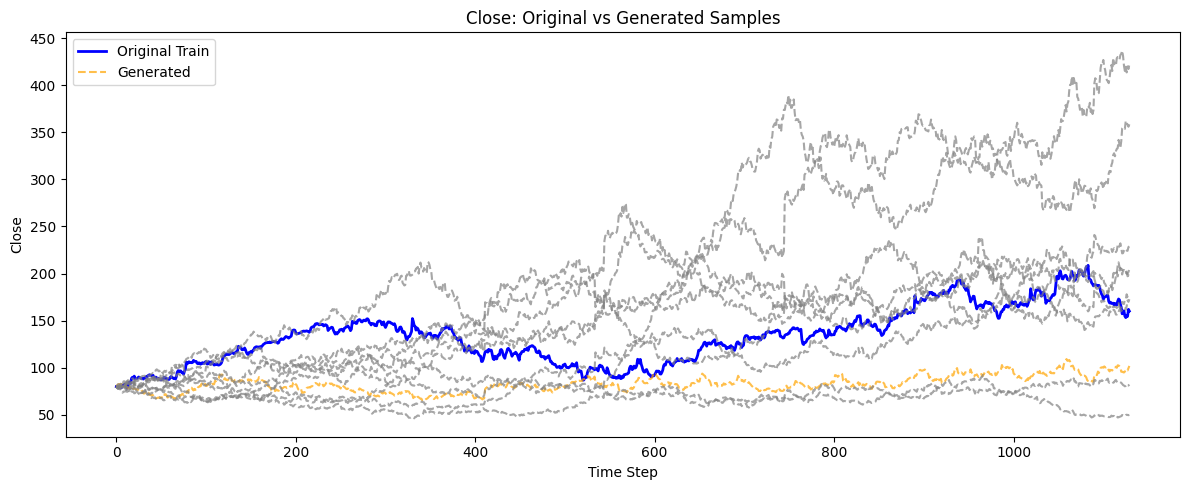

High (channel 3): min=46.7159, max=484.4518, mean=126.8470


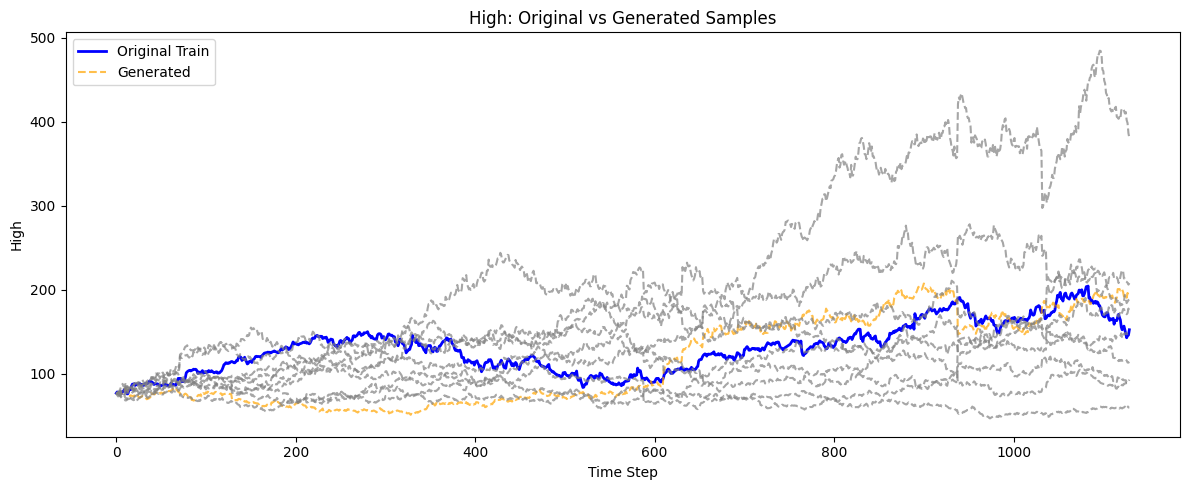

Low (channel 4): min=31.0502, max=692.6893, mean=123.2362


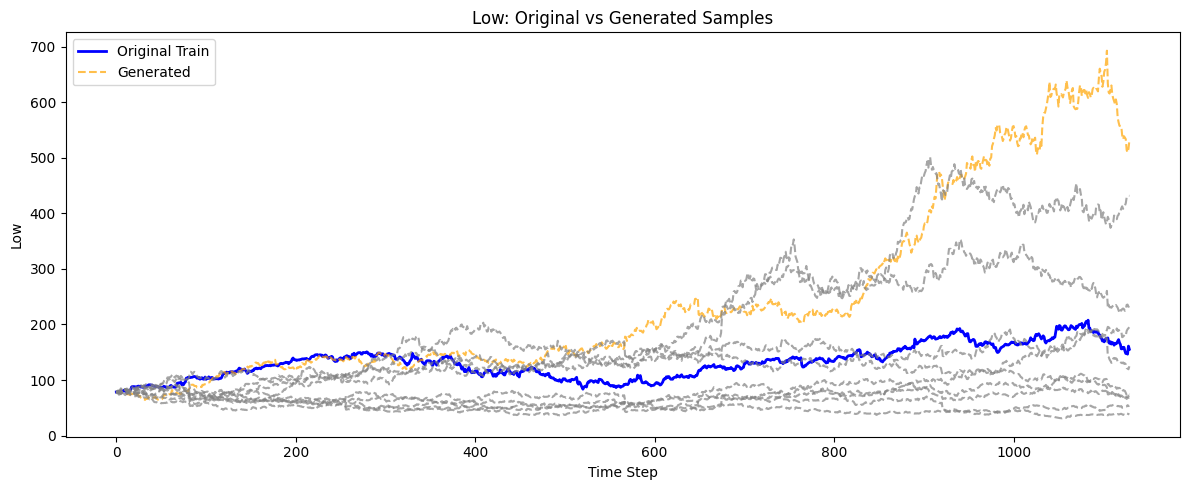

Volume (channel 5): min=0.0000, max=553748355088384.0000, mean=1179776188416.0000


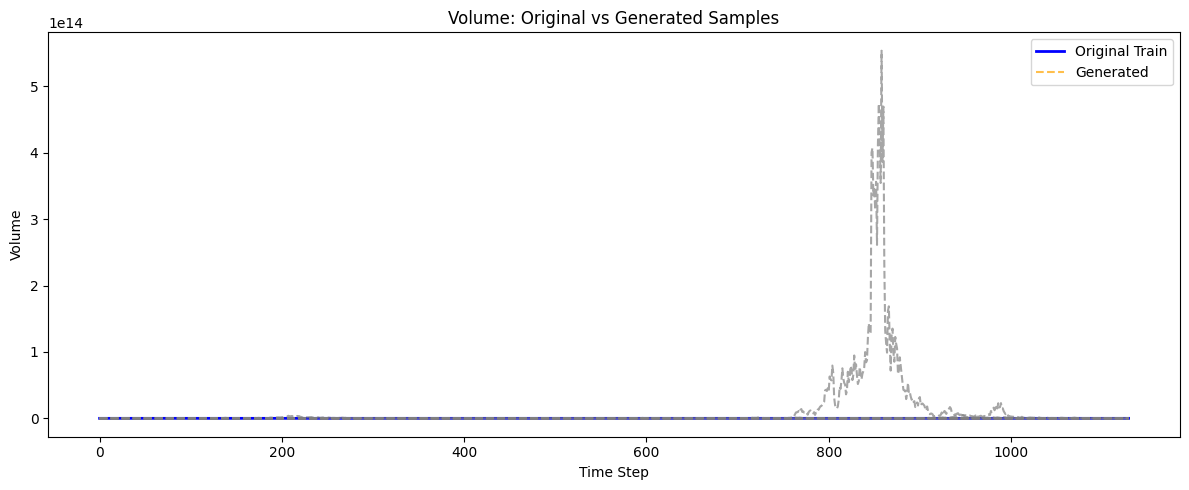

In [7]:
print("\n" + "=" * 50)
print("Validating Merton Jump Diffusion (MJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

mjd_model = MertonJumpDiffusion(length=length, num_channels=num_channels)
print(f"MJD Model instantiated: {mjd_model}")

print("Fitting MJD model...")
mjd_model.fit(train_data_para)

num_generated_samples = 10
mjd_generated_data = mjd_model.generate(num_generated_samples)
print(f"Generated MJD data shape: {mjd_generated_data.shape}")

assert mjd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"MJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {mjd_generated_data.shape}"
print("MJD: Generated data shape is correct.")

plot_outputs(train_data_para, mjd_generated_data, num_generated_samples, length)

### GARCH(1, 1)


Validating GARCH(1,1)
GARCH(1,1) Model instantiated: <src.models.parametric.garch11.GARCH11 object at 0x000001ECC25F8230>
Fitting GARCH(1,1) model...
Generated GARCH(1,1) data shape: torch.Size([10, 1130, 6])
GARCH(1,1): Generated data shape is correct.
Open (channel 1): min=-78.8153, max=471.7349, mean=147.2833


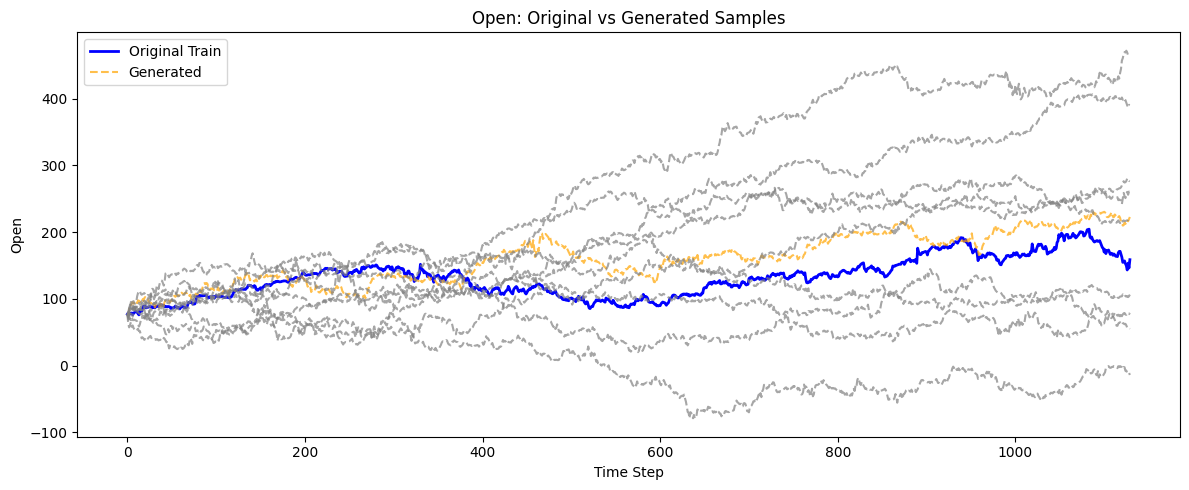

Close (channel 2): min=-56.9995, max=514.2488, mean=136.5350


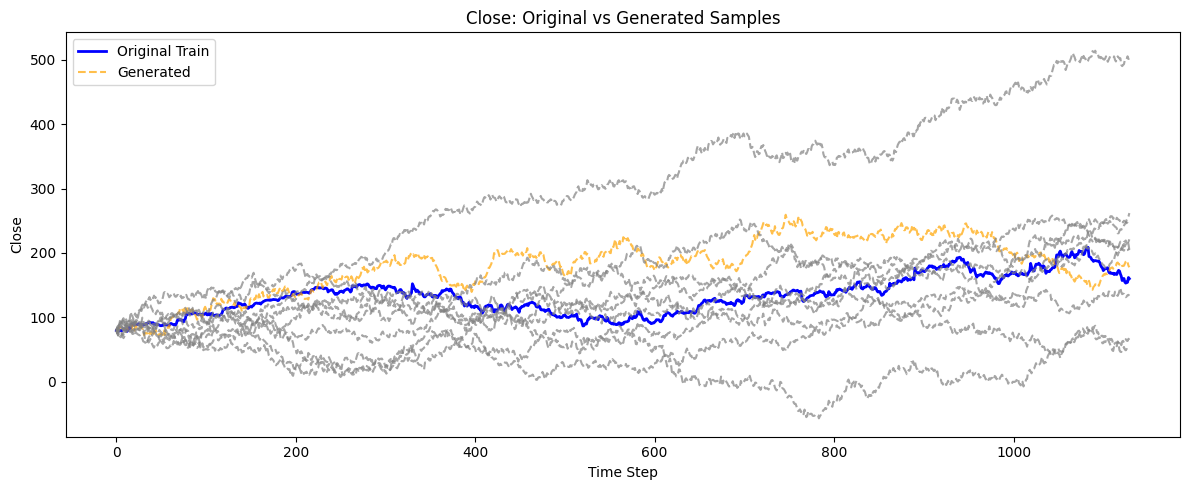

High (channel 3): min=-54.7468, max=384.3519, mean=105.6411


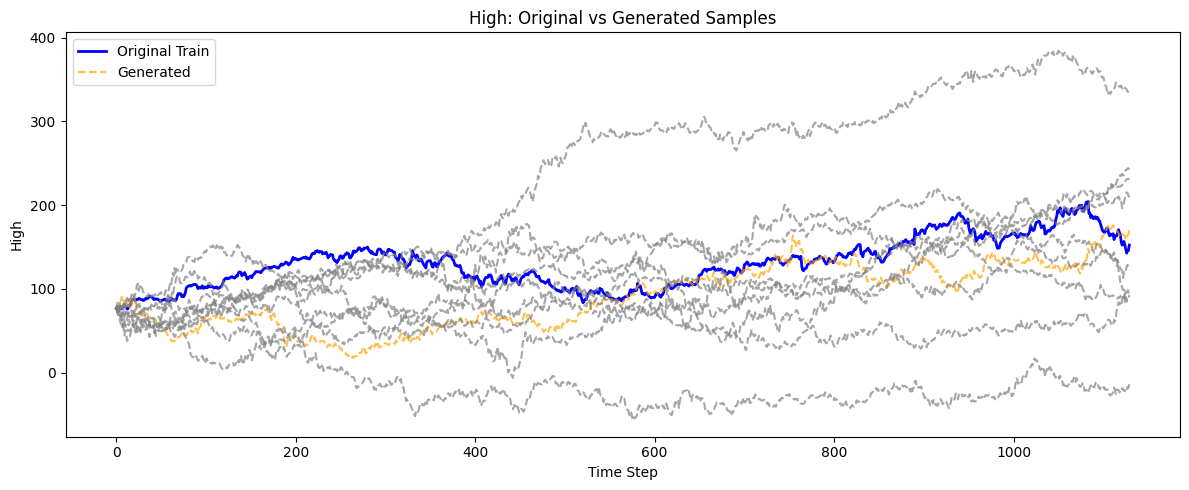

Low (channel 4): min=-150.7891, max=600.2020, mean=126.2574


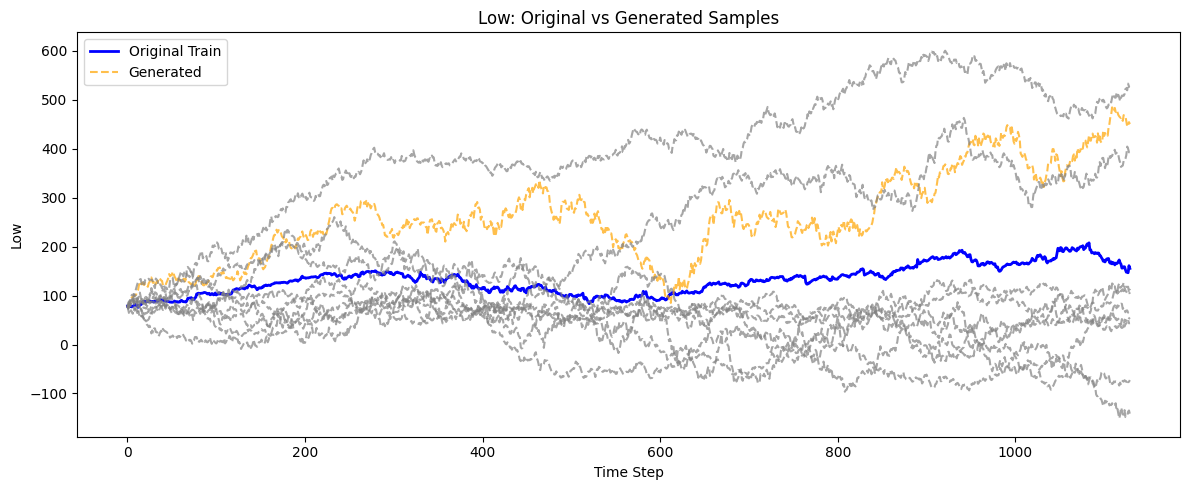

Volume (channel 5): min=-707999872.0000, max=987169280.0000, mean=111874128.0000


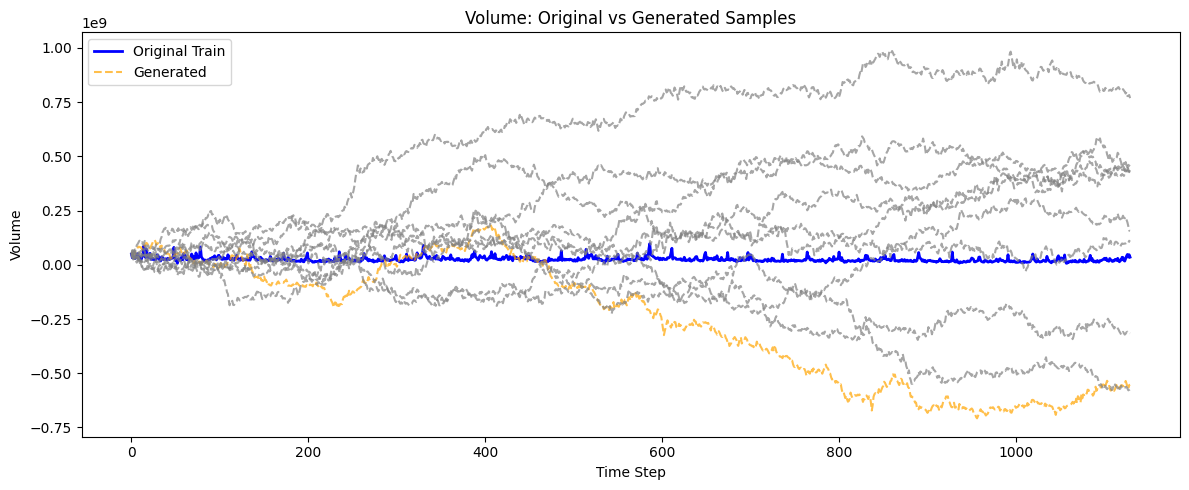

In [8]:
print("\n" + "=" * 50)
print("Validating GARCH(1,1)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

garch_model = GARCH11(length=length, num_channels=num_channels)
print(f"GARCH(1,1) Model instantiated: {garch_model}")

print("Fitting GARCH(1,1) model...")
garch_model.fit(train_data_para)

num_generated_samples = 10
garch_generated_data = garch_model.generate(num_generated_samples)
print(f"Generated GARCH(1,1) data shape: {garch_generated_data.shape}")

assert garch_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"GARCH(1,1): Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {garch_generated_data.shape}"
print("GARCH(1,1): Generated data shape is correct.")

plot_outputs(train_data_para, garch_generated_data, num_generated_samples, length)

### Double Exponential Jump Diffusion


Validating Double Exponential Jump Diffusion (DEJD)
DEJD Model instantiated: <src.models.parametric.garch11.GARCH11 object at 0x000001ECC28B4260>
Fitting DEJD model...
Generated DEJD data shape: torch.Size([10, 1130, 6])
DEJD: Generated data shape is correct.
Open (channel 1): min=17.3708, max=327.2096, mean=127.9641


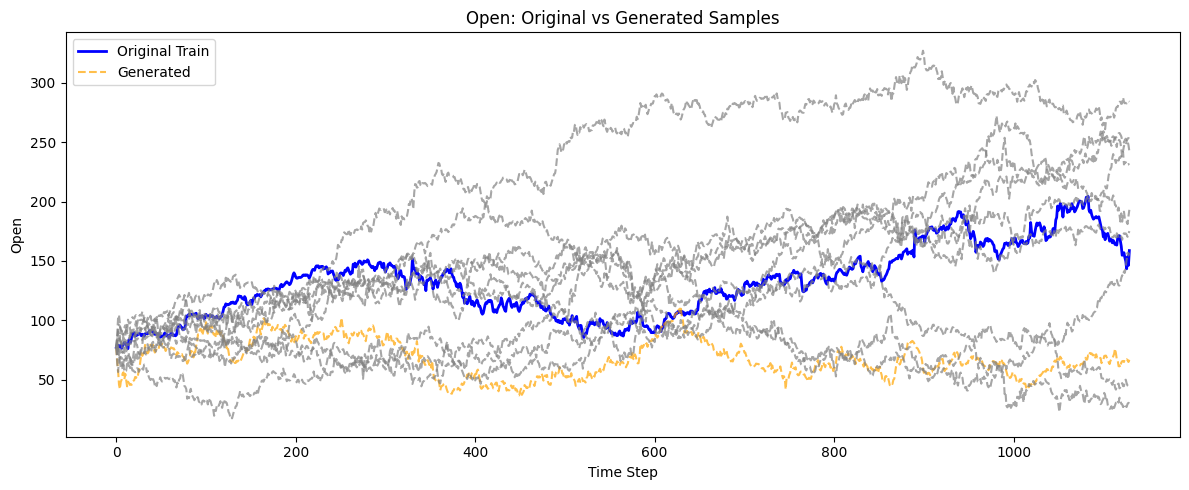

Close (channel 2): min=35.1896, max=395.8096, mean=162.1852


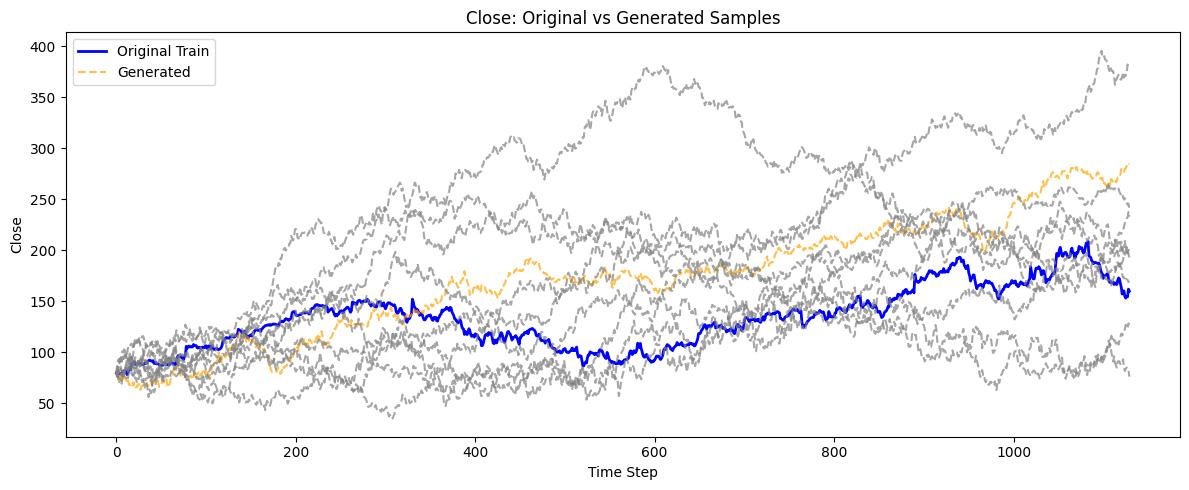

High (channel 3): min=-33.3610, max=332.9846, mean=127.4349


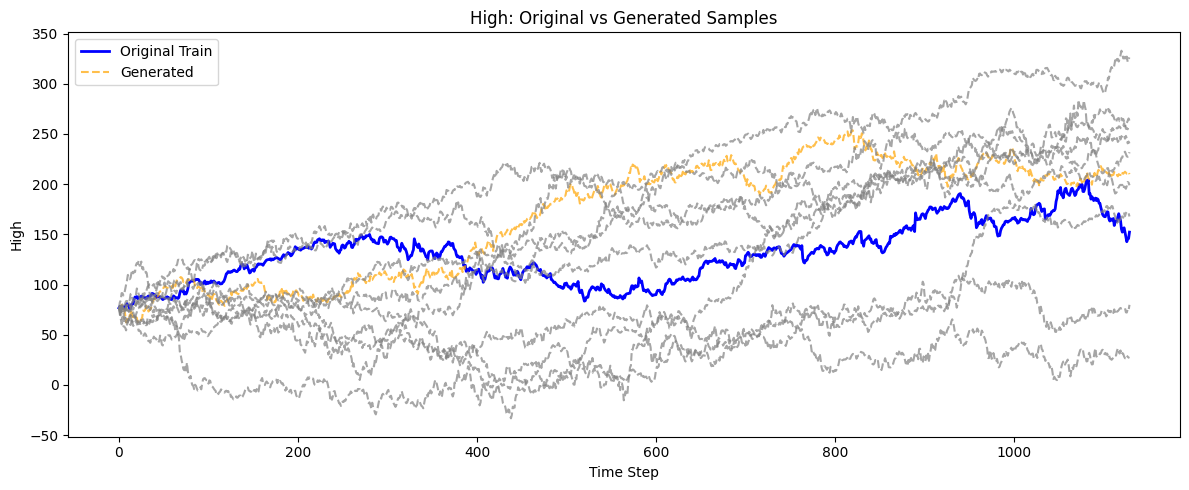

Low (channel 4): min=-206.0224, max=445.4078, mean=70.8426


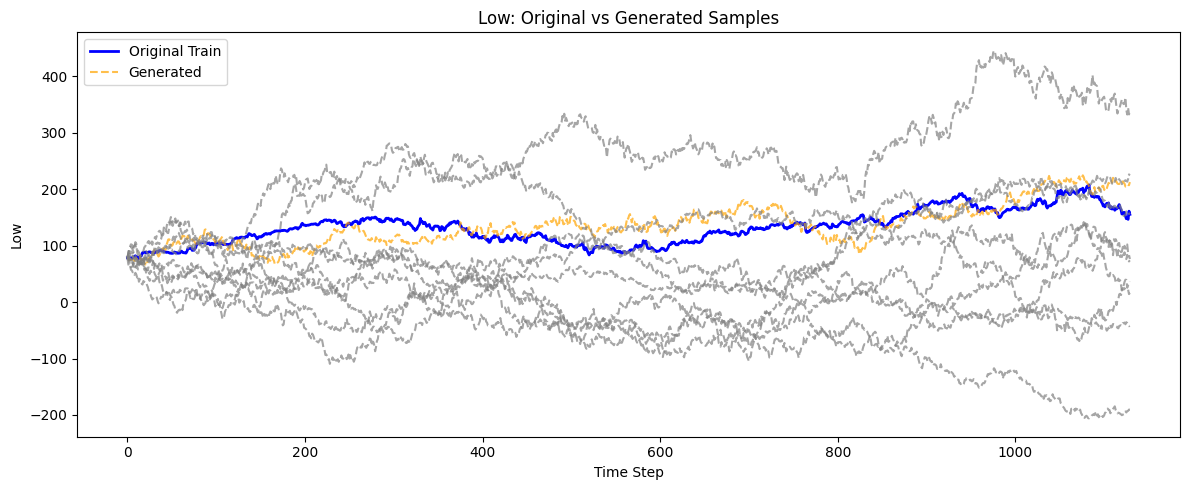

Volume (channel 5): min=-794290752.0000, max=958958208.0000, mean=23622688.0000


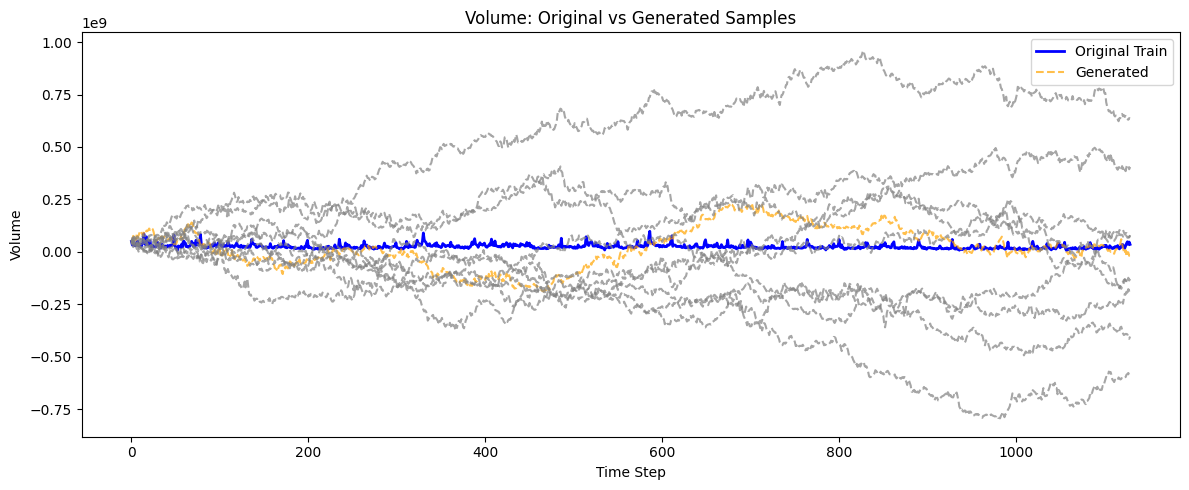

In [9]:
print("\n" + "=" * 50)
print("Validating Double Exponential Jump Diffusion (DEJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

dejd_model = GARCH11(length=length, num_channels=num_channels)
print(f"DEJD Model instantiated: {dejd_model}")

print("Fitting DEJD model...")
dejd_model.fit(train_data_para)

num_generated_samples = 10
dejd_generated_data = dejd_model.generate(num_generated_samples)
print(f"Generated DEJD data shape: {dejd_generated_data.shape}")

assert dejd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"DEJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {dejd_generated_data.shape}"
print("DEJD: Generated data shape is correct.")

plot_outputs(train_data_para, dejd_generated_data, num_generated_samples, length)


Validating Stochastic Volatility Jump Diffusion (SVJD)
SVJD Model instantiated: <src.models.parametric.sv_jump_diffusion.StochasticVolatilityJumpDiffusion object at 0x000001ECC2A24B90>
Fitting SVJD model...
Generated SVJD data shape: torch.Size([10, 1130, 6])
SVJD: Generated data shape is correct.
Open (channel 1): min=9.5604, max=663.9855, mean=95.8959


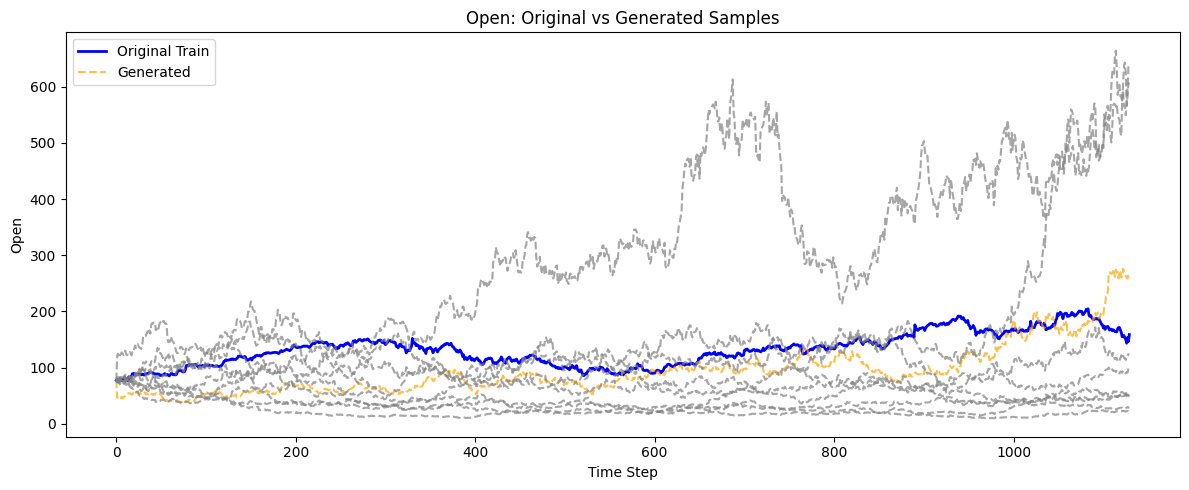

Close (channel 2): min=16.1826, max=1276.9979, mean=130.7845


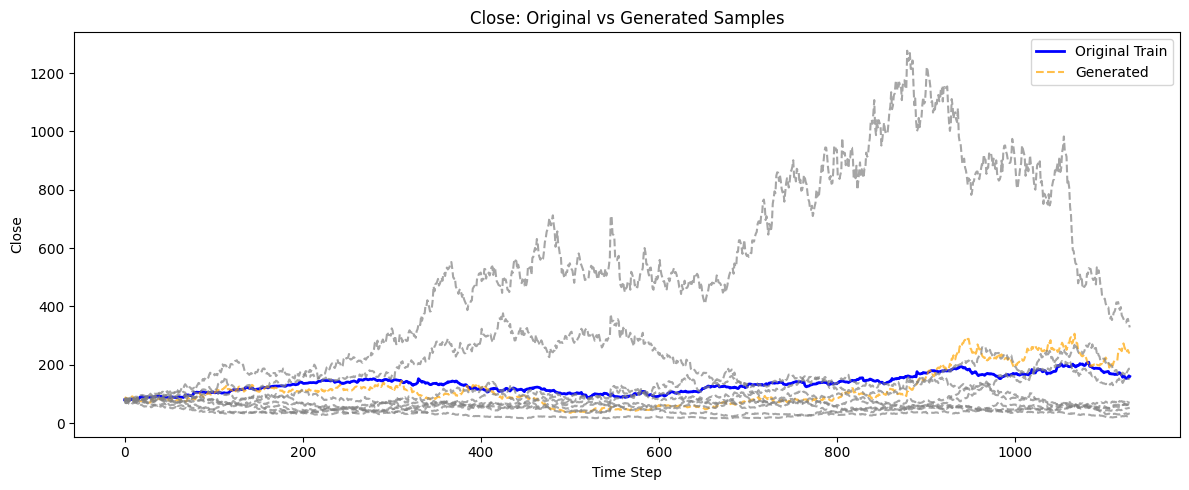

High (channel 3): min=5.8679, max=851.7955, mean=118.4129


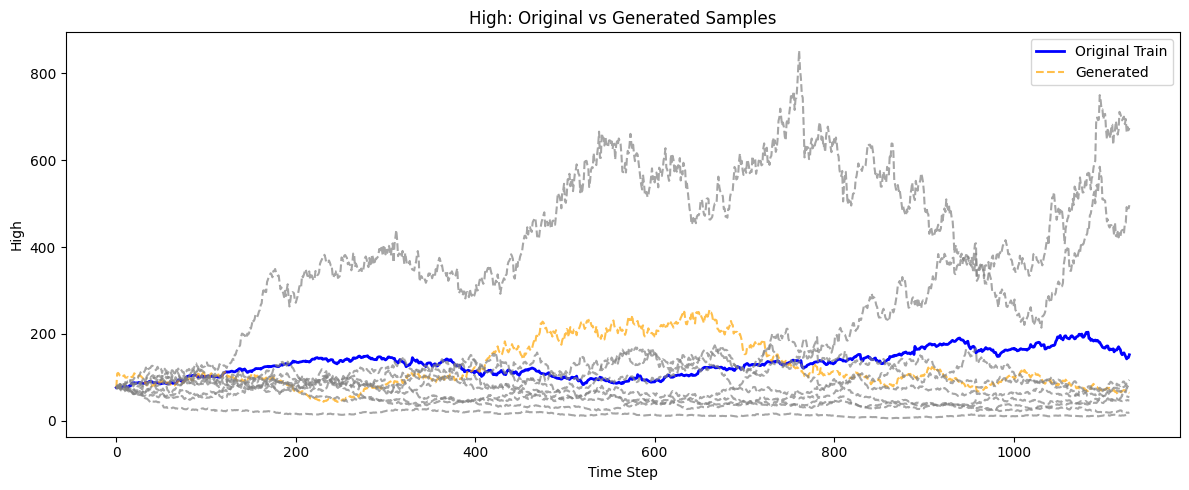

Low (channel 4): min=3.1783, max=188.2845, mean=58.7966


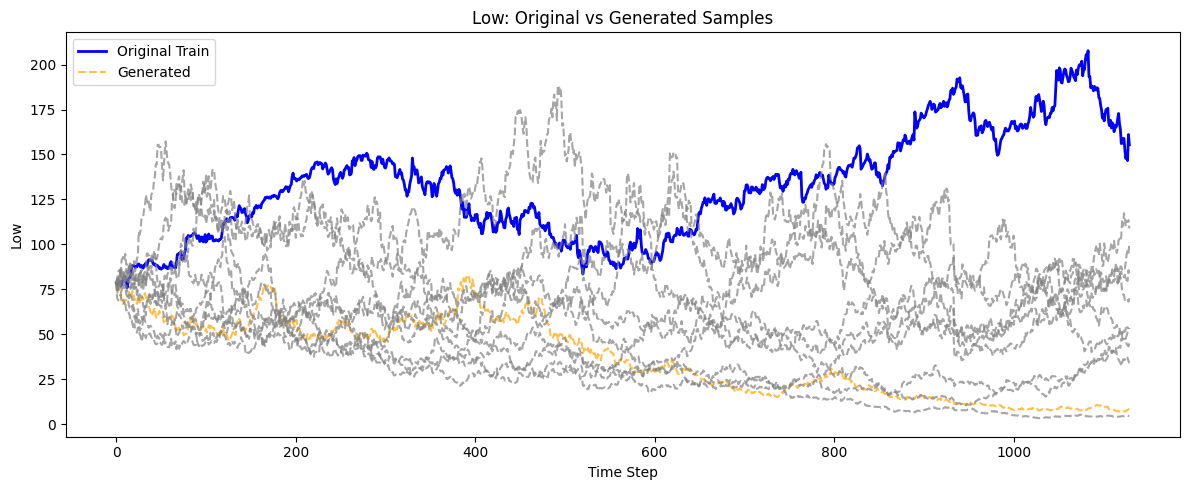

Volume (channel 5): min=0.0000, max=53033792.0000, mean=74349.8672


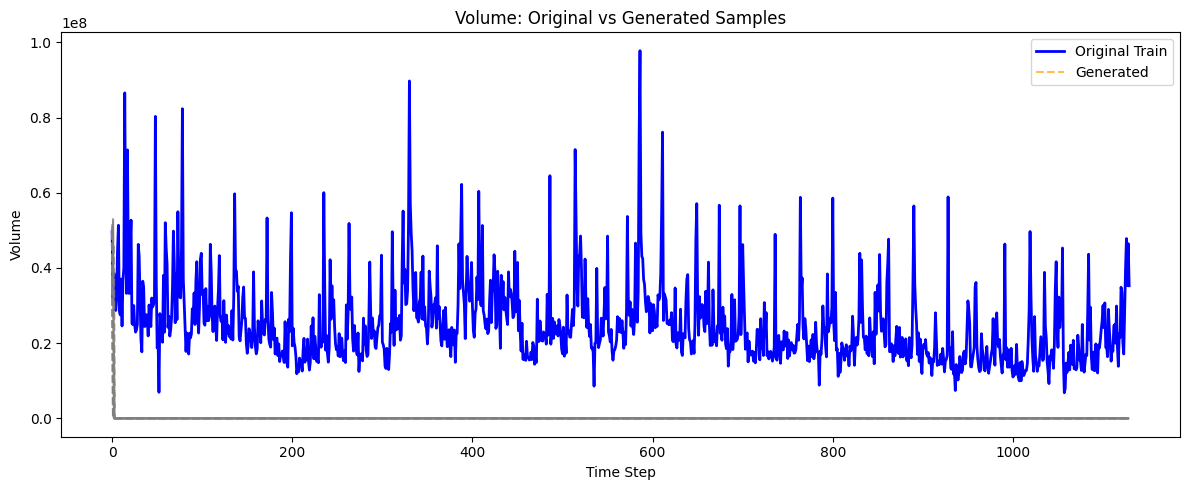

In [10]:
print("\n" + "=" * 50)
print("Validating Stochastic Volatility Jump Diffusion (SVJD)")
print("=" * 50)

length, num_channels = train_data_para.shape
initial_price = train_data_para[0]

svjd_model = StochasticVolatilityJumpDiffusion(length=length, num_channels=num_channels)
print(f"SVJD Model instantiated: {svjd_model}")

print("Fitting SVJD model...")
svjd_model.fit(train_data_para)

num_generated_samples = 10
svjd_generated_data = svjd_model.generate(num_generated_samples)
print(f"Generated SVJD data shape: {svjd_generated_data.shape}")

assert svjd_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"SVJD: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {svjd_generated_data.shape}"
print("SVJD: Generated data shape is correct.")

plot_outputs(train_data_para, svjd_generated_data, num_generated_samples, length)

## Deep Learning Model Validation

This section validates the functionality of each deep learning time series generative model. For each model, we will:
1.  Instantiate the model with appropriate parameters.
2.  Train the model using the preprocessed training data.
3.  Generate new synthetic time series samples.
4.  Verify the shape and basic statistics of the generated data.

Note: GAN training can be unstable and convergence is not guaranteed with simple validation. This is primarily to check code execution and output format.



### Vanilla GAN



In [ ]:
print("\n" + "=" * 50)
print("Validating Vanilla GAN")
print("=" * 50)

# Instantiate Vanilla GAN model
vanilla_gan_model = VanillaGAN(length=length, num_channels=num_channels, latent_dim=64, hidden_dim=128, lr=0.0002)
print(f"Vanilla GAN Model instantiated: {vanilla_gan_model}")

# Fit the model
print("Fitting Vanilla GAN model (this may take a while)...")
vanilla_gan_model.fit(train_loader_norm, num_epochs=50)
print("Vanilla GAN model fitting complete.")

# Generate samples
num_generated_samples = 100

# Prepare timestamps for generated samples
if isinstance(train_data_norm_np, torch.Tensor):
    timestamps_gen = train_loader_norm[0:1, :, 0:1].repeat(num_generated_samples, 1, 1).to(vanilla_gan_model.device)
else:
    timestamps_gen = torch.tensor(train_data_norm_np[0:1, :, 0:1], dtype=torch.float32).repeat(num_generated_samples, 1, 1).to(vanilla_gan_model.device)

vanilla_gan_generated_data = vanilla_gan_model.generate(num_generated_samples, timestamps_gen)
print(f"Generated Vanilla GAN data shape: {vanilla_gan_generated_data.shape}")

# Validation checks
assert vanilla_gan_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"Vanilla GAN: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {vanilla_gan_generated_data.shape}"
print("Vanilla GAN: Generated data shape is correct.")

print(f"Vanilla GAN: Generated data min: {vanilla_gan_generated_data.min():.4f}, "
      f"max: {vanilla_gan_generated_data.max():.4f}, mean: {vanilla_gan_generated_data.mean():.4f}")

# Plot the results for Vanilla GAN simulation
plot_outputs(train_data_norm_np, vanilla_gan_generated_data, num_generated_samples, length)





Validating Vanilla GAN
Vanilla GAN Model instantiated: VanillaGAN(
  (generator): TimeConditionedGenerator(
    (model): Sequential(
      (0): Linear(in_features=8125, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=256, out_features=625, bias=True)
    )
  )
  (discriminator): TimeConditionedDiscriminator(
    (model): Sequential(
      (0): Linear(in_features=750, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=1, bias=True)
      (5): Sigmoid()
    )
  )
  (bce_loss): BCELoss()
)
Fitting Vanilla GAN model (this may take a while)...
Vanilla GAN model fitting complete.
Generated Vanilla GAN data shape: torch.Size([100, 125, 6])
Vanilla GAN: Generated data s

NameError: name 'train_data_para' is not defined

### Wasserstein GAN



In [ ]:
print("\n" + "=" * 50)
print("Validating Wasserstein GAN")
print("=" * 50)

# Instantiate Wasserstein GAN model
# Using a smaller num_epochs for quicker validation, adjust as needed
wasserstein_gan_model = WassersteinGAN(length=length, num_channels=num_channels, latent_dim=64, hidden_dim=128, lr=0.00005, n_critic=5, clip_value=0.01)
print(f"Wasserstein GAN Model instantiated: {wasserstein_gan_model}")

# Fit the model
print("Fitting Wasserstein GAN model (this may take a while)...")
wasserstein_gan_model.fit(train_loader_norm, num_epochs=50)
print("Wasserstein GAN model fitting complete.")

# Generate samples
num_generated_samples = 100
wasserstein_gan_generated_data = wasserstein_gan_model.generate(num_generated_samples)
print(f"Generated Wasserstein GAN data shape: {wasserstein_gan_generated_data.shape}")

# Validation checks
assert wasserstein_gan_generated_data.shape == (num_generated_samples, length, num_channels), \
    f"Wasserstein GAN: Generated data shape mismatch. Expected ({num_generated_samples}, {length}, {num_channels}), got {wasserstein_gan_generated_data.shape}"
print("Wasserstein GAN: Generated data shape is correct.")

print(f"Wasserstein GAN: Generated data min: {wasserstein_gan_generated_data.min():.4f}, max: {wasserstein_gan_generated_data.max():.4f}, mean: {wasserstein_gan_generated_data.mean():.4f}")




Validating Wasserstein GAN
Wasserstein GAN Model instantiated: WassersteinGAN(
  (generator): Generator(
    (model): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=256, out_features=625, bias=True)
    )
  )
  (critic): Critic(
    (model): Sequential(
      (0): Linear(in_features=625, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)
Fitting Wasserstein GAN model (this may take a while)...
Wasserstein GAN model fitting complete.
Generated Wasserstein GAN data shape: torch.Size([100, 125, 5])
Wasserstein GAN: Generated data shape is correct.
Wasserstein GAN: Generated data min: -0.2017, 